# Dependencies

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import warnings

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools


# Understanding of the dataset
The [dataset](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset) contains different 
black and white images of people with different emotions. The emotions classified within the dataset are the following:
- Angry
- Disgust
- Fear
- Happy
- Neutral
- Sad
- Surprise

Additionally, the dataset has already been split for the training set and testing set (named as validation). With this, 
we would be looking at the number of images per each classification for both the training set and testing set

## Checking of label split in dataset
It appears that the training set and testing set has a similar ratio on each of the classifications with the *happy* 
having the most images and *disgust* having the least number of images in both of the sets.

In [2]:
# Fetches the images in all of the folders in the dataset
# Returns a dictionary with the key being the label and the value being the list containing the pathfile to the image 
def get_images(dataset_type):
    folder_paths = glob.glob(f'images/{dataset_type}/*')
    image_dataset = []
    # Process each folder and get all images. Add each of the images to the dataset in pandas
    for folder_path in folder_paths:
        all_images = glob.glob(f"{folder_path}/*.jpg")
        label = folder_path.split('\\')[-1]
        for image in all_images:
            image_data = {'image_path': image, 'label': label}
            image_dataset.append(image_data)
    
    # Transform data into a pandas DataFrame
    image_dataset = pd.DataFrame(image_dataset)
    return image_dataset


# Takes input of a dataframe, and creates a barplot of the distribution of each of the labels of the dataset
def visualize_dataset(dataset: pd.DataFrame(), title = None):
    dataset['label'].value_counts().plot(kind='bar')
    plt.title(title, fontsize=15)
    plt.ylabel('Count')
    plt.xlabel('Emotion')
    plt.show()

In [3]:
training_set = get_images('train')
testing_set = get_images('validation')

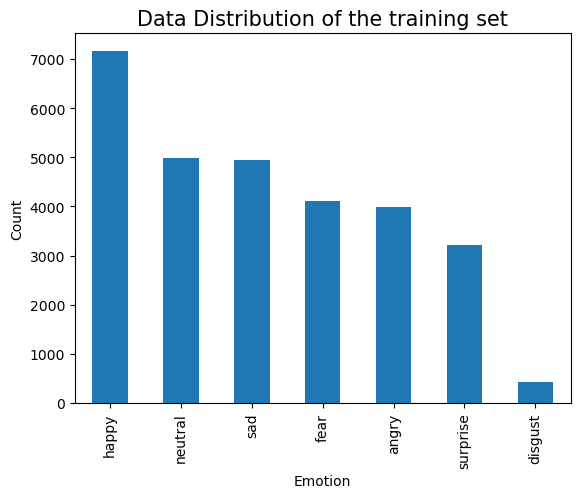

In [4]:
visualize_dataset(training_set, "Data Distribution of the training set")

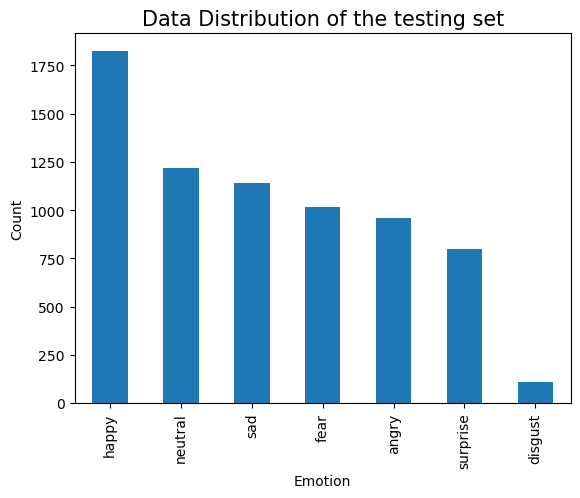

In [5]:
visualize_dataset(testing_set, "Data Distribution of the testing set")

## Checking of Image properties
Now, we'll check a one sample from each of the classification in the dataset to see if there's any preprocessing that 
could be done on the images.

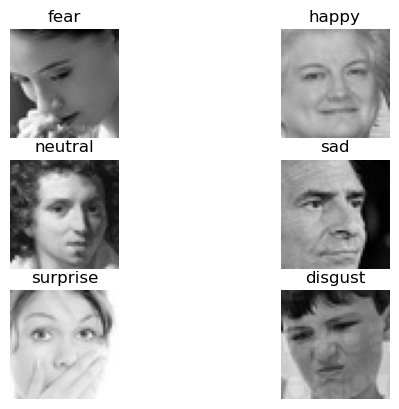

In [6]:
sample_images_path = []

# Getting one image for each of the classification and adding it to sample_images_path
for label in training_set['label'].unique():
    image_path = training_set[training_set['label'] == label]['image_path'].iloc[0]
    sample_images_path.append(image_path)

# Visualizing the images in one plot with the label of the image on top
f, axs = plt.subplots(3,2)
for i in range(len(sample_images_path)):
    image_data = cv2.imread(sample_images_path[i])
    axs[i//2-1, i%2].axis('off')
    label = sample_images_path[i].split('\\')[-2]
    axs[i//2-1, i%2].title.set_text(label)
    axs[i//2-1, i%2].imshow(image_data)

It appears that images are already black and white within the dataset. Next we have to ensure that the images have the 
same sizes. Checking in the image's metadata, it appears that the images in the dataset has already been resized to 
a consistent shape of 48x48x1 and have already been preprocessed to be a black and white image.

# Opening of images
Now that we've finished analyzing and preprocessing the data, its time to load the data. In order to use the labels in the model,
we have to first transform the label into integers then one-hot encode them to be able to use categorical_crossentropy. 
One-hot encoding was done to the labels because the labels does not have any ordinal correlation to each other.

In [7]:
# Takes in a pandas dataframe to open the image path and get the label of the image
# Returns two arrays, one containing the image's pixel values, and the other as the label of said image
def get_image_data(dataset: pd.DataFrame):
    image_data = []
    image_labels = []
    for image in dataset.itertuples():
        image_file = cv2.imread(image[1])

        # Convert the file into a gray image so that the number of dimensions is reduced to one
        image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2GRAY)

        # Add image information to both image_data and image_labels
        image_data.append(image_file)
        image_labels.append(image[2])
    return image_data, image_labels

In [8]:
encoder = LabelEncoder()
# Gets the data and transform the labels into numerical values with the LabelEncoder
train_data, train_labels = get_image_data(training_set)
train_data = np.array(train_data)

# Encode the labels into integer values then one-hot encode them as the labels do not have ordinal correlation to e/o
encoder.fit(list(set(train_labels)))
train_labels = encoder.fit_transform(train_labels)
train_labels = to_categorical(train_labels,7)

test_data, test_labels = get_image_data(testing_set)
test_data = np.array(test_data)
test_labels = encoder.fit_transform(test_labels)
test_labels = to_categorical(test_labels,7)

# Model Training
In getting the facial recognition of the person in the image, we'll be using a slightly modified version of VGG16 where 
the input shape would be (48,48,1) instead of (224,224,3)

In [9]:
# Model architecture of VGG-16 modified to take an input shape of 48,48,1 and have a 7 classification output

model = Sequential()
model.add(Conv2D(input_shape=(48,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=7, activation="softmax"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                    

c:\Users\SKill\anaconda3\envs\DL\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
# Training of the model and testing of the model with the validation_data
history = model.fit(train_data, train_labels, batch_size=256, epochs=75, validation_data=(test_data, test_labels))

Epoch 1/75
113/113 [==============================] - 24s 148ms/step - loss: 3.6202 - accuracy: 0.2429 - val_loss: 1.8090 - val_accuracy: 0.2583
Epoch 2/75
113/113 [==============================] - 12s 109ms/step - loss: 1.8120 - accuracy: 0.2487 - val_loss: 1.8040 - val_accuracy: 0.2577
Epoch 3/75
113/113 [==============================] - 13s 113ms/step - loss: 1.8088 - accuracy: 0.2474 - val_loss: 1.7983 - val_accuracy: 0.2583
Epoch 4/75
113/113 [==============================] - 13s 116ms/step - loss: 1.7617 - accuracy: 0.2718 - val_loss: 1.6785 - val_accuracy: 0.3200
Epoch 5/75
113/113 [==============================] - 13s 115ms/step - loss: 1.6258 - accuracy: 0.3432 - val_loss: 1.5930 - val_accuracy: 0.3760
Epoch 6/75
113/113 [==============================] - 13s 113ms/step - loss: 1.5314 - accuracy: 0.3902 - val_loss: 1.5097 - val_accuracy: 0.4101
Epoch 7/75
113/113 [==============================] - 12s 108ms/step - loss: 1.4502 - accuracy: 0.4245 - val_loss: 1.4217 - val_ac

# Model Result Analysis
In this section, we would be analyzing different graphs to check the model's performance in predicting emotion through 
images

In [15]:
# Create plots to check progress of model over time
def create_plot(history, metric, title):
    plt.plot(history[metric], label=metric)
    plt.plot(history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(title, fontsize=20)
    plt.legend()
    plt.show()

## Accuracy Over Epochs
With the current model, with an epoch of 75, it appears that the model has some overfitting issues starting at around 
the 10th epoch where the training accuracy increased exponential to more than 90% 10 epochs later. With this, it would 
be recommended to lower the number of epochs that the model uses to avoid overfitting of the model.

Looking now at the results of the predictions, with about **57%** accuracy in the final epoch, the model is able to perform 
better than randomly guessing the classification of the image; as randomly guessing would result in about 14.3% 
accuracy.

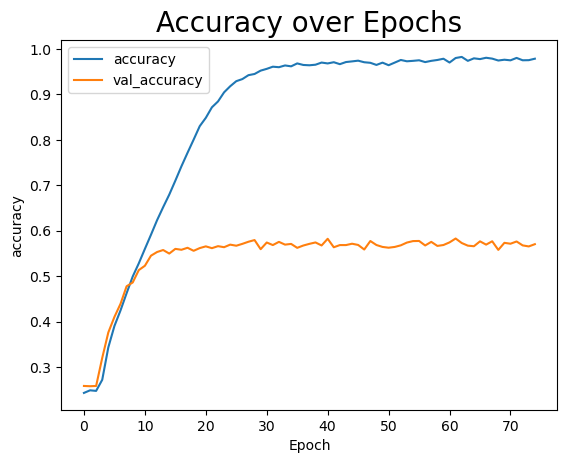

In [19]:
# Create the plot for accuracy
create_plot(history.history, 'accuracy', 'Accuracy over Epochs')

## Loss over Epochs
This graph confirms that overfitting has indeed happened with the model where the difference between the validation 
loss and the training loss is significant starting at the 10th epoch. With this, the model should have been stopped at 
around the 10th epoch as the accuracy and loss of the model did not improve much after the said epoch.

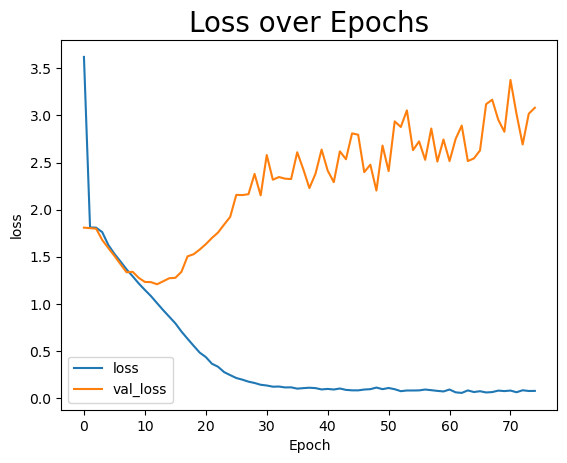

In [20]:
# Create the plot for loss
create_plot(history.history, 'loss', 'Loss over Epochs')

In [34]:
# Predict the emotion and convert them to their original label of emotion
y_predict = model.predict(test_data)
y_predict = np.argmax(y_predict, axis=1)
y_true = np.argmax(test_labels, axis=1)

y_predict = encoder.inverse_transform(y_predict)
y_true = encoder.inverse_transform(y_true)

221/221 [==============================] - 2s 8ms/step


In [42]:
# Get accuracy of the model
accuracy = accuracy_score(y_true, y_predict)
print(f"Accuracy of the model in prediction the label: {accuracy*100:.2f}%")

Accuracy of the model in prediction the label: 57.05%


## Confusion Matrix of Emotions in the Testing Set
Looking at the confusion matrix, we can see that each of the classifications was confused with the following:
- **Angry**: Fear, Neutral, Sad
- **Disgust**: Angry, Fear
- **Fear**: Angry, Sad, Neutral
- **Happy**: Neutral, Fear, Sad
- **Neutral**: Sad, Fear, Happy
- **Sad**: Neutral, Happy, Angry
- **Surprise**: Fear

Further more, looking at the individual F1-Scores of each of the labels, we can see that the Angry label had the highest F1-score getting 0.78, while surprise and disgust had the lowest score with about 0.42. We can see on the confusion matrix that the model.


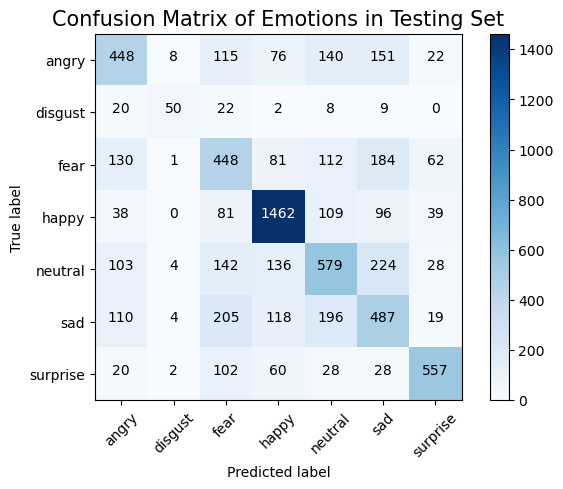

In [53]:
confusion_mat = confusion_matrix(y_true, y_predict)

# Create confusion matrix of the predicted and true labels
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix of Emotions in Testing Set',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


all_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(confusion_mat, classes = all_classes)

In [55]:
# Calculates the confusion matrix for each of the classifcation in the dataset
def calculate_confusion_matrix(y_true, y_pred, all_labels):
    # Get all labels
    unique_labels = all_labels
    num_labels = len(unique_labels)
    label_to_index = {label: index for index, label in enumerate(unique_labels)}
    # Create the confusion matrix
    confusion_matrix = [[0] * num_labels for _ in range(num_labels)]

    for true_label, pred_label in zip(y_true, y_pred):
        true_index = label_to_index[true_label]
        pred_index = label_to_index[pred_label]
        confusion_matrix[true_index][pred_index] += 1

    return confusion_matrix

# Calculates the F1 score of each of the labels in the dataset
def calculate_f1_score(confusion_matrix, labels):
    f1_scores = {}

    for label in labels:
        label_index = labels.index(label)
        tp = confusion_matrix[label_index][label_index]
        fp = sum(confusion_matrix[i][label_index] for i in range(len(confusion_matrix)) if i != label_index)
        fn = sum(confusion_matrix[label_index][i] for i in range(len(confusion_matrix)) if i != label_index)

        if tp == 0 and (fp == 0 or fn == 0):
            precision = 0
            recall = 0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)

        if precision + recall == 0:
            f1_score = 0
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)

        f1_scores[label] = f1_score

    return f1_scores

confusion_matrix = calculate_confusion_matrix(y_true, y_predict)
f1_scores = calculate_f1_score(confusion_matrix, all_classes)

for label, f1_score in f1_scores.items():
    print("Label:", label)
    print("F1 Score:", f1_score)
    print()


Label: angry
F1 Score: 0.7776595744680851

Label: disgust
F1 Score: 0.4201898188093184

Label: fear
F1 Score: 0.7309711286089239

Label: happy
F1 Score: 0.5555555555555556

Label: neutral
F1 Score: 0.48988518316019686

Label: sad
F1 Score: 0.4849246231155779

Label: surprise
F1 Score: 0.42006563525550866

